# Predict soil moisture using precipitation, temperature, and vegetation photosynthesis

In [1]:
import pandas as pd
import torch
from torch import nn
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


%matplotlib inline

## Check the data and pre-process

In [2]:
filename = 'C:/Users/ywang254/OneDrive - University of Tennessee/Teaching/JupyterNotebooks/data/FLX_US-Goo_FLUXNET2015_FULLSET_2002-2006_1-4/FLX_US-Goo_FLUXNET2015_FULLSET_DD_2002-2006_1-4.csv'
data = pd.read_csv(filename, na_values=['-9999'])

data.head()

,TIMESTAMP,TA_F_MDS,TA_F_MDS_QC,TA_F_MDS_NIGHT,TA_F_MDS_NIGHT_SD,TA_F_MDS_NIGHT_QC,TA_F_MDS_DAY,TA_F_MDS_DAY_SD,TA_F_MDS_DAY_QC,TA_ERA,...,GPP_DT_CUT_SE,GPP_DT_CUT_05,GPP_DT_CUT_16,GPP_DT_CUT_25,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N
0,20020101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.226,...,0.041361,2.38229,2.63922,2.82186,2.88915,2.90387,2.93763,3.11636,NaN,NaN
1,20020102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.529,...,0.041916,2.56876,2.82693,3.01319,3.09143,3.10662,3.13866,3.31744,NaN,NaN
2,20020103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.900,...,0.043211,2.70189,2.96726,3.15977,3.24393,3.25969,3.29196,3.47542,NaN,NaN
3,20020104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.042,...,0.043361,2.73586,3.00172,3.19511,3.28117,3.29702,3.32906,3.51279,NaN,NaN
4,20020105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.357,...,0.025963,1.07617,1.21415,1.34969,1.36642,1.38638,1.40002,1.51923,NaN,NaN


In [3]:
# keep only the necessary variables
data['TIMESTAMP'] = data['TIMESTAMP'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
data = data.loc[:, ['TIMESTAMP','TA_F','P_F','GPP_NT_VUT_REF','SWC_F_MDS_1']].set_index('TIMESTAMP')

# Remove the missing values
data = data.dropna(axis = 0, how = 'any')
data.head()

,TA_F,P_F,GPP_NT_VUT_REF,SWC_F_MDS_1
TIMESTAMP,,,,
2002-04-21,23.490,1.388,5.13611,32.364
2002-04-22,17.646,0.373,5.38256,32.210
2002-04-23,17.616,0.000,6.33965,32.186
2002-04-24,22.820,1.305,5.07481,32.364
2002-04-25,15.219,0.105,5.15864,32.210


array([[<AxesSubplot:title={'center':'TA_F'}>,
        <AxesSubplot:title={'center':'P_F'}>],
       [<AxesSubplot:title={'center':'GPP_NT_VUT_REF'}>,
        <AxesSubplot:title={'center':'SWC_F_MDS_1'}>]], dtype=object)

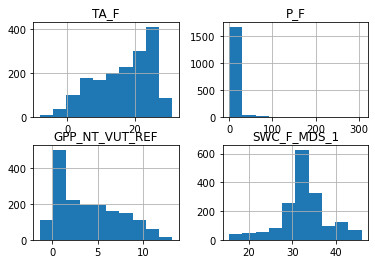

In [4]:
# Look at the distributions
data.hist()

array([[<AxesSubplot:title={'center':'TA_F'}>,
        <AxesSubplot:title={'center':'P_F'}>],
       [<AxesSubplot:title={'center':'GPP_NT_VUT_REF'}>,
        <AxesSubplot:title={'center':'SWC_F_MDS_1'}>]], dtype=object)

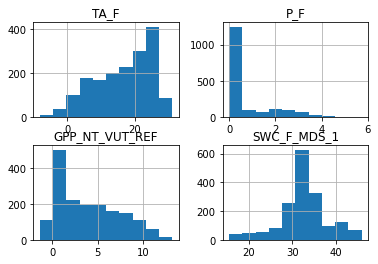

In [5]:
# Log-transform the precipitation data
data['P_F'] = np.log(data['P_F'] + 1)
data.hist()

In [6]:
data.to_csv('test.csv')

Text(0, 0.5, 'Gross Primary Productivity (gC m-2 d-1)')

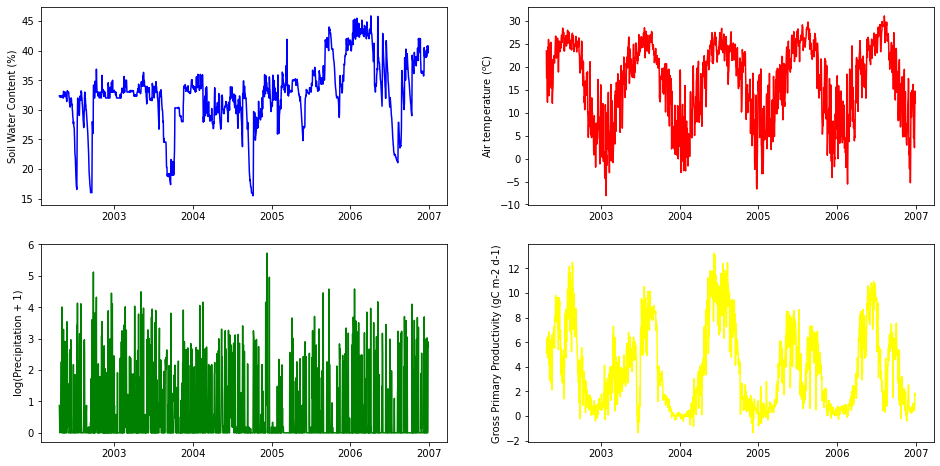

In [7]:
# Check the time series
fig, axes = plt.subplots(2, 2, figsize=(16,8))

ax = axes.flat[0]
ax.plot(data.index, data['SWC_F_MDS_1'], color = 'blue')
ax.set_ylabel('Soil Water Content (%)')

ax = axes.flat[1]
ax.plot(data.index, data['TA_F'], color = 'red')
ax.set_ylabel('Air temperature ($^o$C)')

ax = axes.flat[2]
ax.plot(data.index, data['P_F'], color = 'green')
ax.set_ylabel('log(Precipitation + 1)') # mm d-1

ax = axes.flat[3]
ax.plot(data.index, data['GPP_NT_VUT_REF'], color = 'yellow')
ax.set_ylabel('Gross Primary Productivity (gC m-2 d-1)')

In [8]:
# Check the correlations
corrMatrix = data.corr()
corrMatrix.style.background_gradient(cmap ='RdBu')\
                                    .set_properties(**{'font-size': '20px'})

,TA_F,P_F,GPP_NT_VUT_REF,SWC_F_MDS_1
TA_F,1.000000,0.062329,0.682142,-0.321199
P_F,0.062329,1.000000,-0.079265,0.066958
GPP_NT_VUT_REF,0.682142,-0.079265,1.000000,-0.212514
SWC_F_MDS_1,-0.321199,0.066958,-0.212514,1.000000


#### Note

Since this dataset's missing values are at the beginning, it is okay to use just dropna. 
If a dataset has missing values in the middle, the temporal continuity will be broken. 
In that case, the segments before and after the missing values can be used as different batches. Each batch does not have to be the same size. 

In [9]:
# Normalize and divide into train-test sets
X_set = data.loc[:, ['TA_F', 'P_F', 'GPP_NT_VUT_REF', 'SWC_F_MDS_1']].values
X_set = (X_set - X_set.min(axis = 0)) / (X_set.max(axis = 0) - X_set.min(axis = 0))

# Define a test size
test_size = 180

# Create train and test sets
X_train = torch.FloatTensor(X_set[:-test_size, :])
X_test = torch.FloatTensor(X_set[-test_size:, :])

# Create batches
def prepare_batches(matrix, batch_size, seq_size):
    out_x = []
    out_y = []
    L = matrix.shape[0]
    for i in range(L-seq_size):
        if np.mod(i, batch_size) == 0:
            batch_x = []
            batch_y = []

        window = matrix[i:i+seq_size, :-1]
        # note only the last column is the predictand
        label = matrix[(i+seq_size-1):(i+seq_size), -1]
        batch_x.append(window)
        batch_y.append(label)

        if np.mod(i, batch_size) == (batch_size - 1):
            batch_x = torch.stack(batch_x)
            out_x.append(batch_x)
            out_y.append(torch.FloatTensor(batch_y))

    out_y = torch.stack(out_y)
    return out_x, out_y

# Define the batch size and sequence size
batch_size = 3
seq_size = 120

train_x, train_y = prepare_batches(X_train, batch_size, seq_size)
test_x, test_y = prepare_batches(X_test, batch_size, seq_size)

# Prepend the last 120 training set to the test set, to enable the model to predict the first 120
test_x = train_x[-(seq_size//2):] + test_x
test_y = torch.cat((train_y[-(seq_size//2):], test_y))

print(f'The size of a training batch is {train_x[0].detach().numpy().shape}')
print(f'The number of training batches is {len(train_x)}')

print(f'The size of a test batch is {test_x[0].detach().numpy().shape}')
print(f'The number of test batches is {len(test_x)}')

The size of a training batch is (3, 120, 3)
The number of training batches is 472
The size of a test batch is (3, 120, 3)
The number of test batches is 80


## Define the LSTM Model

In [10]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1,batch_size=1,dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size

        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

        # Add a drop-out layer:
        self.dropout = nn.Dropout(p=dropout)

        # Add a fully-connected layer:
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,batch_size,self.hidden_size),
                       torch.zeros(1,batch_size,self.hidden_size))

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        last_h = self.dropout(lstm_out[:, -1, :]) # we only want the last value in the sequence
        pred = self.fc(last_h)
        return pred

## Instantiate the model, define loss and optimization functions

In [11]:
torch.manual_seed(101)
model = LSTMnetwork(input_size = 3, hidden_size = 100, output_size = 1, batch_size = batch_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(3, 100, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [12]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  1200
 40000
   400
   400
   100
     1
______
 42101


## Train the model

In [13]:
epochs = 100
losses = []

for i in range(epochs):

    # tuple-unpack the train_data set
    for batch_x, batch_y in zip(train_x, train_y):
        model.hidden = (torch.zeros(1,batch_size,model.hidden_size),
                        torch.zeros(1,batch_size,model.hidden_size))
        y_pred = model(batch_x)

        loss = criterion(y_pred, batch_y.view(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.detach().numpy())

    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')

Epoch:  1 Loss: 0.00935122
Epoch:  2 Loss: 0.00510347
Epoch:  3 Loss: 0.00698571
Epoch:  4 Loss: 0.00503459
Epoch:  5 Loss: 0.01231691
Epoch:  6 Loss: 0.01045392
Epoch:  7 Loss: 0.01090314
Epoch:  8 Loss: 0.01115369
Epoch:  9 Loss: 0.01430629
Epoch: 10 Loss: 0.01094660
Epoch: 11 Loss: 0.00963274
Epoch: 12 Loss: 0.01238648
Epoch: 13 Loss: 0.00739885
Epoch: 14 Loss: 0.01294342
Epoch: 15 Loss: 0.00870991
Epoch: 16 Loss: 0.01072887
Epoch: 17 Loss: 0.00732022
Epoch: 18 Loss: 0.00831813
Epoch: 19 Loss: 0.01119446
Epoch: 20 Loss: 0.01177995
Epoch: 21 Loss: 0.01373100
Epoch: 22 Loss: 0.01190583
Epoch: 23 Loss: 0.01235142
Epoch: 24 Loss: 0.01086832
Epoch: 25 Loss: 0.01036084
Epoch: 26 Loss: 0.01180190
Epoch: 27 Loss: 0.01054984
Epoch: 28 Loss: 0.01189360
Epoch: 29 Loss: 0.01233732
Epoch: 30 Loss: 0.00950520
Epoch: 31 Loss: 0.00968214
Epoch: 32 Loss: 0.00948417
Epoch: 33 Loss: 0.00808934
Epoch: 34 Loss: 0.00946571
Epoch: 35 Loss: 0.00942226
Epoch: 36 Loss: 0.00753769
Epoch: 37 Loss: 0.00706968
E

Text(0.5, 0, 'epoch')

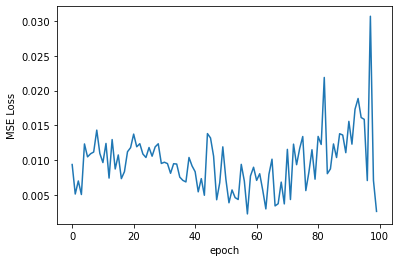

In [14]:
plt.plot(range(epochs), losses)
plt.ylabel('MSE Loss')
plt.xlabel('epoch')

## Run predictions and compare to known test set

In [15]:
future = len(test_y)

preds = []

# Set the model to evaluation mode
model.eval()

for i in range(future):
    with torch.no_grad():
        model.hidden = (torch.zeros(1,batch_size,model.hidden_size),
                        torch.zeros(1,batch_size,model.hidden_size))
        preds.append(model(test_x[i]).reshape(batch_size))

preds = torch.stack(preds)

print('MSE Loss: ', criterion(test_y, preds))

preds = preds.detach().numpy().reshape(-1)
y_val = test_y.detach().numpy().reshape(-1)

MSE Loss:  tensor(0.0068)


Text(0.5, 0, 'Time')

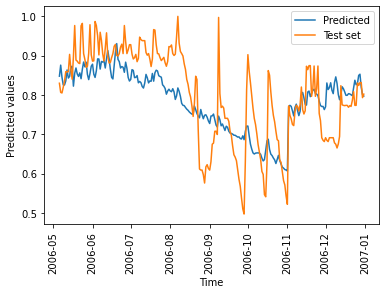

In [16]:
fig, ax = plt.subplots()
ax.plot(data.index[(-test_size*2+seq_size):], preds, label = 'Predicted')
ax.plot(data.index[(-test_size*2+seq_size):], y_val, label = 'Test set')
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylabel('Predicted values')
plt.xlabel('Time')